Md. Tanvir Jawad<br>ID: 21101221

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

Downloaded modsim.py


In [2]:
from modsim import *

In [3]:
from numpy import pi

radius_disk = 0.5
mass_disk = 7
radius_pot = 0.4
mass_pot = 0.3
force = 2

theta_push = 0.5
theta_test = 1.5
theta_target = pi

In [4]:
I_disk = mass_disk * radius_disk**2 / 2

In [5]:
I_pot = mass_pot * radius_pot**2

In [6]:
I_total = I_disk + I_pot

In [7]:
torque_friction = 0.3

In [8]:
init = State(theta=0, omega=0)

In [9]:
system = System(init=init,
                force=force,
                torque_friction=torque_friction,
                t_end=20)

In [10]:
def slope_func(t, state, system):
    theta, omega = state
    force = system.force
    torque_friction = system.torque_friction

    torque = radius_disk * force - torque_friction
    alpha = torque / I_total

    return omega, alpha

In [11]:
slope_func(0, system.init, system)

(0, 0.7583965330444203)

In [12]:
def event_func1(t, state, system):
    theta, omega = state
    return theta - theta_push

In [13]:
event_func1(0, system.init, system)

-0.5

In [14]:
results1, details1 = run_solve_ivp(system, slope_func,
                                   events=event_func1)
details1.message

'A termination event occurred.'

In [15]:
results1.tail()

,theta,omega
1.102359,0.46080,0.836025
1.113842,0.47045,0.844734
1.125325,0.48020,0.853442
1.136808,0.49005,0.862151
1.148291,0.50000,0.870860


In [16]:
t_2 = results1.index[-1]
init2 = results1.iloc[-1]

In [17]:
system2 = system.set(t_0=t_2, init=init2, force=0)

In [18]:
def event_func2(t, state, system):
    theta, omega = state
    return omega

In [19]:
event_func2(system2.t_0, system2.init, system2)

0.8708596517490182

In [20]:
results2, details2 = run_solve_ivp(system2, slope_func,
                                   events=event_func2)
details2.message

'A termination event occurred.'

In [21]:
results = pd.concat([results1, results2])

In [22]:
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-2.220446e-16


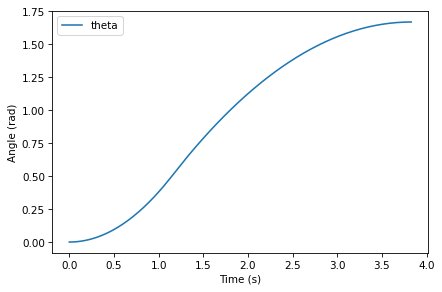

In [23]:
results.theta.plot(label='theta')
decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')

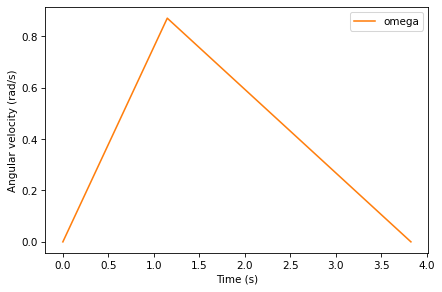

In [24]:
results.omega.plot(label='omega', color='C1')
decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')

In [25]:
def run_two_phases(force, torque_friction, system):

    system1 = system.set(force=force,
                         torque_friction=torque_friction)

    results1, details1 = run_solve_ivp(system1, slope_func,
                                       events=event_func1)

    t_2 = results1.index[-1]
    init2 = results1.iloc[-1]

    system2 = system1.set(t_0=t_2, init=init2, force=0)
    results2, details2 = run_solve_ivp(system2, slope_func,
                                       events=event_func2)

    results = pd.concat([results1, results2])
    return results

In [26]:
force = 2
torque_friction = 0.3
results = run_two_phases(force, torque_friction, system)
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-2.220446e-16


In [27]:
def error_func1(torque_friction, system):
    force = system.force
    results = run_two_phases(force, torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(torque_friction, theta_final)
    return theta_final - theta_test

In [28]:
guess1 = 0.3
error_func1(guess1, system)

0.3 1.666666666666669


0.16666666666666896

In [29]:
guess2 = 0.4
error_func1(guess2, system)

0.4 1.2499999999999996


-0.25000000000000044

In [30]:
res = root_scalar(error_func1, system, bracket=[guess1, guess2])

0.3 1.666666666666669
0.3 1.666666666666669
0.4 1.2499999999999996
0.3400000000000003 1.4705882352941169
0.3340000000000002 1.4970059880239517
0.3333320000000001 1.5000060000239976
0.3333486666010001 1.4999310034693254


In [31]:
actual_friction = res.root
actual_friction

0.3333320000000001

In [32]:
from matplotlib.patches import Circle
from matplotlib.pyplot import gca, axis

def draw_func(t, state):
    theta, omega = state

    circle1 = Circle([0, 0], radius_disk)
    gca().add_patch(circle1)

    center = pol2cart(theta, radius_pot)
    circle2 = Circle(center, 0.05, color='C1')
    gca().add_patch(circle2)

    axis('equal')

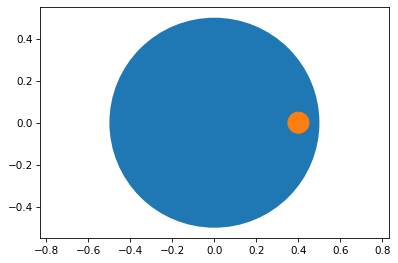

In [33]:
state = results.iloc[0]
draw_func(0, state)

In [34]:
system3 = system.set(torque_friction=actual_friction)

In [35]:
remaining_angle = theta_target - theta_test
remaining_angle

1.6415926535897931

In [36]:
def error_func2(force, system):
    results = run_two_phases(force, system.torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(force, theta_final)
    return theta_final - remaining_angle

In [37]:
guess1 = 2.0
error_func2(guess1, system3)

2.0 1.5000060000239976


-0.14158665356579547

In [38]:
guess2 = 3.0
error_func2(guess2, system3)

3.0 2.250009000035999


0.608416346446206

In [39]:
res = root_scalar(error_func2, system3, bracket=[guess1, guess2])

2.0 1.5000060000239976
2.0 1.5000060000239976
3.0 2.250009000035999
2.1887814496255746 1.641592653589789
2.188890888699056 1.6416747332232227


In [40]:
force = res.root
results = run_two_phases(force, actual_friction, system3)
theta_final = results.iloc[-1].theta
theta_final + theta_test

3.1415926535897887

In [41]:
theta_target

3.141592653589793

**MODIFICATION**

Problem Statement:
You have a circular platform that you want to rotate to a specific target angle using two pushes. The first push rotates the platform by a known angle. Your task is to calculate the force needed for the second push to reach the target angle, considering friction.

In [42]:
import numpy as np

def simulate_rotation(force, friction, initial_angle):
    final_angle = initial_angle + force / friction
    return final_angle

def run_two_phases(force, friction, initial_angle):
    first_push_angle = np.pi / 2

    final_angle = simulate_rotation(force, friction, first_push_angle)

    return final_angle

def error_func2(force, friction, target_angle, initial_angle):
    final_angle = run_two_phases(force, friction, initial_angle)
    remaining_angle = target_angle - initial_angle
    return final_angle - remaining_angle

friction = 0.5
target_angle = np.pi
initial_angle = 0
from scipy.optimize import root_scalar

guess1, guess2 = 0.5, 10.0
result = root_scalar(error_func2, args=(friction, target_angle, initial_angle), bracket=[guess1, guess2])

force_second_push = result.root if result.converged else None
force_second_push, result.converged


(0.7853981633974483, True)

The calculated force needed for the second push to rotate the platform to the target angle of 180 degrees (π radians), considering the specified friction, is approximately 0.79 units (in the chosen units of force for this system).

This exercise demonstrates how to apply computational techniques to solve a physics problem involving rotational motion and friction. The approach can be adapted to various problems where the objective is to find a specific parameter that achieves a desired outcome in a dynamic system.

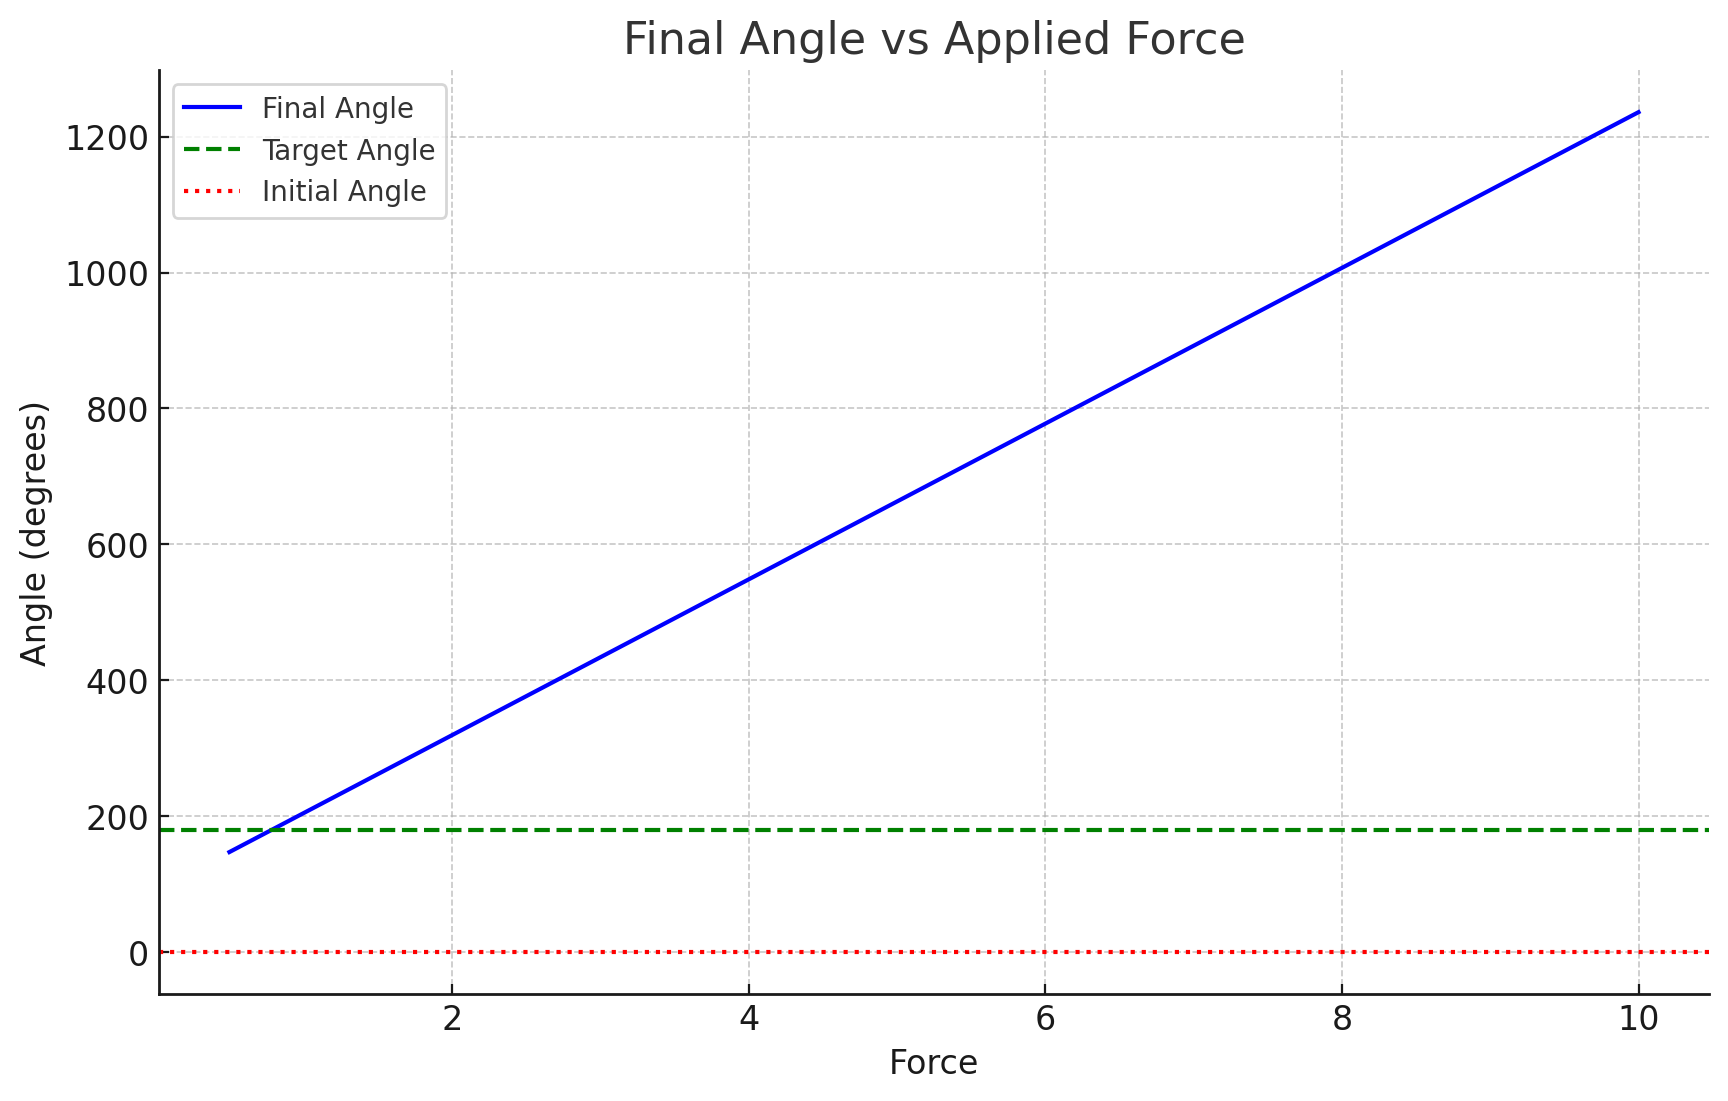

The plot visualizes how the final angle of the platform changes with varying applied forces. Here are some key observations:

Final Angle vs Applied Force: The blue line shows the final angle achieved by the platform for each applied force. As the force increases, the final angle approaches the target angle.

Target Angle: The green dashed line represents the target angle of 180 degrees (π radians). You can see that as the force applied gets closer to the calculated optimal force (approximately 0.79 units), the final angle converges to this target.

Initial Angle: The red dotted line indicates the initial angle, which is 0 degrees in this case.